In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from scipy.linalg import circulant
from numpy import linalg as LA
import preprocess as pr
from keras.preprocessing import sequence
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Conv1D,MaxPooling1D,Flatten,LSTM,Dropout,BatchNormalization,Activation

from keras.preprocessing import sequence

Using TensorFlow backend.


In [2]:
os.chdir("/Polycarbon/hand Motion Clasification")

In [3]:
def read_in_folder(folder_path,gesture_num):
    x=[]
    y=[]
    for file in os.listdir(folder_path):
        if( "-L-" in file ):  
            if(gesture_num!=1):
                d = pr.read_emg(folder_path+"/"+file)
                d= d.dropna().astype(float)
                if(d.Time.size>300):
                    T =  pr.find_active_time(d.Time,d.loc[:,['gx','gy','gz']])
                    print(folder_path+"/"+file)
                    if (len(T)==2):
                        x.append(d[d.Time>=T[0]].T.values[1:])
                        y.append(gesture_num)
            else:
                print(folder_path+"/"+file)
                d = pr.read_emg(folder_path+"/"+file)
                d= d.dropna().astype(float)
                x.append(d.T.values[1:])
                y.append(gesture_num)
    return x,y

x = []
y = []
for sample in os.listdir("Data/")[1:10]:
    if(os.path.isdir("Data/"+sample) and sample!=".ipynb_checkpoints"):
        for i in range(1,14):
            filename = "M"+str(i)+"-"+sample  
            if len(os.listdir("Data/"+sample+"/"+filename))==2:
                for fd in os.listdir("Data/"+sample+"/"+filename):
                    filepath="Data/"+sample+"/"+filename+"/"+fd+"/"
                    u,v = read_in_folder(filepath,i)
            else:
                filepath="Data/"+sample+"/"+filename
                u,v = read_in_folder(filepath,i)
            x.extend(u)
            y.extend(v)

Data/Amnoey/M1-Amnoey/test-L-0.csv
Data/Amnoey/M1-Amnoey/test-L-1.csv
Data/Amnoey/M1-Amnoey/test-L-2.csv
Data/Amnoey/M1-Amnoey/test-L-3.csv
Data/Amnoey/M1-Amnoey/test-L-4.csv
Data/Amnoey/M1-Amnoey/test-L-5.csv
Data/Amnoey/M1-Amnoey/test-L-6.csv
Data/Amnoey/M1-Amnoey/test-L-7.csv
Data/Amnoey/M1-Amnoey/test-L-8.csv
Data/Amnoey/M1-Amnoey/test-L-9.csv
Data/Amnoey/M2-Amnoey/test-L-0.csv
Data/Amnoey/M2-Amnoey/test-L-1.csv
Data/Amnoey/M2-Amnoey/test-L-2.csv
Data/Amnoey/M2-Amnoey/test-L-3.csv
Data/Amnoey/M2-Amnoey/test-L-4.csv
Data/Amnoey/M2-Amnoey/test-L-5.csv
Data/Amnoey/M2-Amnoey/test-L-6.csv
Data/Amnoey/M2-Amnoey/test-L-7.csv
Data/Amnoey/M2-Amnoey/test-L-8.csv
Data/Amnoey/M2-Amnoey/test-L-9.csv
Data/Amnoey/M3-Amnoey/test-L-0.csv
Data/Amnoey/M3-Amnoey/test-L-1.csv
Data/Amnoey/M3-Amnoey/test-L-2.csv
Data/Amnoey/M3-Amnoey/test-L-3.csv
Data/Amnoey/M3-Amnoey/test-L-4.csv
Data/Amnoey/M3-Amnoey/test-L-5.csv
Data/Amnoey/M3-Amnoey/test-L-6.csv
Data/Amnoey/M3-Amnoey/test-L-7.csv
Data/Amnoey/M3-Amnoe

KeyboardInterrupt: 

# Histogram of window lenght 

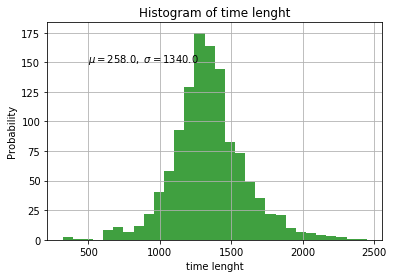

In [55]:

v = [len(x[i][0]) for i in range(len(x))]
# the histogram of the data
n, bins, patches = plt.hist(v, 30, density=False, facecolor='g', alpha=0.75)

mu = np.std(v)
sigma = np.average(v)
plt.xlabel('time lenght')
plt.ylabel('Probability')
plt.title('Histogram of time lenght')
plt.text(500, 150, r'$\mu='+str(np.trunc(mu))+',\ \sigma='+str(np.trunc(sigma))+'$')
plt.grid(True)
plt.show()

# build model function

In [58]:
def build_model(window_length,feature_length):
    input_signal = Input(shape=(feature_length,window_length),name="input_signal")
    x = Conv1D(filters=32, kernel_size=3,activation='relu', padding='same')(input_signal)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(filters=16, kernel_size=200,activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(filters=8, kernel_size=200,activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
#     x = LSTM(100, return_sequences=False)(x)
#     x = Dropout(0.5)(x)
    x = Flatten()(x)
    x = Dense(output_dim = 80, init = 'uniform', activation = 'relu')(x)
    dense_out = Dense(13, activation="sigmoid" ,name ="output_Dense")(x)
    
    model=Model(inputs=[input_signal], outputs=[dense_out])
        
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [165]:
# #normalize
# g=np.array([normalize(x[0]) for i in range(len(y))])
#padding
X=np.array([sequence.pad_sequences(b, padding="post",maxlen=2000,dtype='float32')for b in x])

# feature Selection

['Smooth-Ch0','Smooth-Ch1','Smooth-Ch2','Smooth-Ch3','Smooth-Ch4','Smooth-Ch5','Smooth-Ch6','Smooth-Ch7','ax','ay','az','gx','gy','gz']

In [166]:
X.shape

(1184, 30, 2000)

In [201]:
Xf1=X[:,16:]

In [202]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( Xf1,y,test_size=0.5,stratify=y)

model=build_model(Xf1.shape[2],Xf1.shape[1])  
model.fit(X_train, pd.get_dummies(y_train), batch_size = 10, nb_epoch = 90)


C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=80, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/90
592/592 [==============================] - 1s 2ms/step - loss: 2.5716 - acc: 0.0878
Epoch 2/90
592/592 [==============================] - 0s 500us/step - loss: 2.5358 - acc: 0.0845TA: 0s - loss: 2.5448 - acc: 0.0
Epoch 3/90
592/592 [==============================] - 0s 500us/step - loss: 2.4460 - acc: 0.1267
Epoch 4/90
592/592 [==============================] - 0s 516us/step - loss: 2.3487 - acc: 0.1807
Epoch 5/90
592/592 [==============================] - 0s 497us/step - loss: 2.2152 - acc: 0.2179
Epoch 6/90
592/592 [==============================] - 0s 500us/step - loss: 2.0258 - acc: 0.2753
Epoch 7/90
592/592 [==============================] - 0s 526us/step - loss: 1.9290 - acc: 0.2551
Epoch 8/90
592/592 [==============================] - ETA: 0s - loss: 1.8268 - acc: 0.332 - 0s 519us/step - loss: 1.8211 - acc: 0.3328
Epoch 9/90
592/592 [==============================] - 0s 527us/step - loss: 1.6191 - acc: 0.4274
Epoch 10/90
592/592 [==============================] - 0s 5

In [203]:
scores = model.evaluate([X_test], pd.get_dummies(y_test))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

592/592 [==============================] - 0s 463us/step

acc: 76.69%


Confusion matrix, without normalization
[[31  0  2  0  0  6  2  4  0  0  0  0  0]
 [ 0 35  2  0  0  1  1  0  0  2  0  3  1]
 [ 2  0 37  1  1  1  5  0  0  1  0  0  0]
 [ 7  0  2 33  0  2  3  0  0  0  0  0  0]
 [ 0  2  0  0 40  0  0  1  1  0  0  0  1]
 [ 0  0  0  1  0 46  1  1  0  0  0  0  0]
 [ 2  0  9  3  5  3 18  4  0  0  0  1  0]
 [ 0  0  1  0  0  2  2 35  0  0  1  0  4]
 [ 1  0  1  0  0  0  0  0 36  1  0  1  1]
 [ 0  1  1  0  0  0  2  0  1 36  5  0  0]
 [ 1  0  1  0  0  0  3  0  0  0 35  5  0]
 [ 0  3  0  2  0  0  1  0  1  3  0 35  0]
 [ 1  0  0  0  0  0  0  3  0  0  5  0 37]]


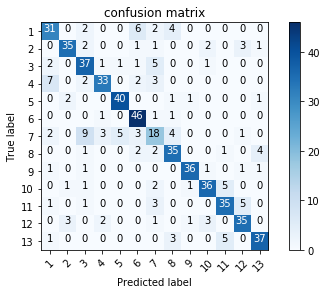

Normalized confusion matrix
[[0.69 0.   0.04 0.   0.   0.13 0.04 0.09 0.   0.   0.   0.   0.  ]
 [0.   0.78 0.04 0.   0.   0.02 0.02 0.   0.   0.04 0.   0.07 0.02]
 [0.04 0.   0.77 0.02 0.02 0.02 0.1  0.   0.   0.02 0.   0.   0.  ]
 [0.15 0.   0.04 0.7  0.   0.04 0.06 0.   0.   0.   0.   0.   0.  ]
 [0.   0.04 0.   0.   0.89 0.   0.   0.02 0.02 0.   0.   0.   0.02]
 [0.   0.   0.   0.02 0.   0.94 0.02 0.02 0.   0.   0.   0.   0.  ]
 [0.04 0.   0.2  0.07 0.11 0.07 0.4  0.09 0.   0.   0.   0.02 0.  ]
 [0.   0.   0.02 0.   0.   0.04 0.04 0.78 0.   0.   0.02 0.   0.09]
 [0.02 0.   0.02 0.   0.   0.   0.   0.   0.88 0.02 0.   0.02 0.02]
 [0.   0.02 0.02 0.   0.   0.   0.04 0.   0.02 0.78 0.11 0.   0.  ]
 [0.02 0.   0.02 0.   0.   0.   0.07 0.   0.   0.   0.78 0.11 0.  ]
 [0.   0.07 0.   0.04 0.   0.   0.02 0.   0.02 0.07 0.   0.78 0.  ]
 [0.02 0.   0.   0.   0.   0.   0.   0.07 0.   0.   0.11 0.   0.8 ]]


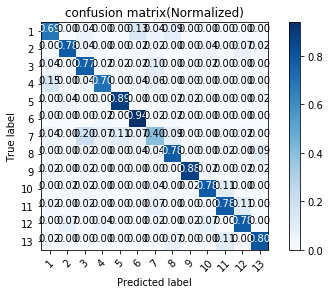

In [204]:
def get_predict(model,X):

    array_p=model.predict([X])
    predict=[np.argmax(i) for i in array_p]
    return  np.array(predict)

prd = get_predict(model,X_test)
confuse_matrix_plot(y_test,prd+1,["1","2","3","4","5","6","7","8","9","10","11","12","13"],title="confusion matrix")

Set2
[ 'Raw-Ch1','Raw-Ch2','Raw-Ch3','Raw-Ch4','Raw-Ch5','Raw-Ch6','Raw-Ch7','Raw-Ch8','ax','ay','az','gx','gy','gz']

In [195]:
Xf2=X[:,8:]

In [198]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( Xf2,y,test_size=0.5,stratify=y)

model=build_model(Xf2.shape[2],Xf2.shape[1])  
model.fit(X_train, pd.get_dummies(y_train), batch_size = 10, nb_epoch = 63)

C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=80, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/63
592/592 [==============================] - 1s 2ms/step - loss: 2.5676 - acc: 0.0811
Epoch 2/63
592/592 [==============================] - 0s 539us/step - loss: 2.5477 - acc: 0.0912
Epoch 3/63
592/592 [==============================] - 0s 537us/step - loss: 2.5528 - acc: 0.0895
Epoch 4/63
592/592 [==============================] - 0s 561us/step - loss: 2.4997 - acc: 0.1115
Epoch 5/63
592/592 [==============================] - 0s 541us/step - loss: 2.4256 - acc: 0.1284
Epoch 6/63
592/592 [==============================] - 0s 544us/step - loss: 2.2884 - acc: 0.1807
Epoch 7/63
592/592 [==============================] - 0s 542us/step - loss: 2.1759 - acc: 0.2280
Epoch 8/63
592/592 [==============================] - 0s 553us/step - loss: 2.0261 - acc: 0.2686
Epoch 9/63
592/592 [==============================] - 0s 558us/step - loss: 1.8743 - acc: 0.2821
Epoch 10/63
592/592 [==============================] - 0s 542us/step - loss: 1.8569 - acc: 0.2736
Epoch 11/63
592/592 [==========

In [199]:
scores = model.evaluate([X_test], pd.get_dummies(y_test))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

592/592 [==============================] - 0s 564us/step

acc: 46.45%


Confusion matrix, without normalization
[[24  0  0  2  0  3  1  2  1  3  6  3  0]
 [ 1 22  2  1  0  0  1  0  0  2  2 11  3]
 [ 8  1 13  1  2  0 13  2  2  6  0  0  0]
 [ 0  0  2 25  0  0  1  1  0  5  4  9  0]
 [ 3  5  0  0 30  0  2  0  0  2  0  1  2]
 [12  0  3  2  0 33  0  0  0  0  0  0  0]
 [ 5  3 12  6  2  0 10  0  0  3  3  1  0]
 [ 4  7  2  2  7  6  1 11  0  0  4  0  2]
 [ 3  0  4  1  0  1  2  1 21  1  1  5  0]
 [ 2  0  5  0  0  3  5  0  1 19  0 10  0]
 [ 0  0  2  0  1  3  1  3  2  0 33  0  0]
 [ 0  1  1  9  0  0  1  0  0 11  0 20  2]
 [ 1  8  0  0 12  3  2  3  0  0  1  2 14]]


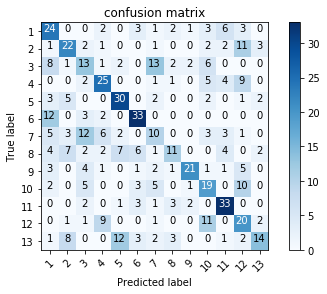

Normalized confusion matrix
[[0.53 0.   0.   0.04 0.   0.07 0.02 0.04 0.02 0.07 0.13 0.07 0.  ]
 [0.02 0.49 0.04 0.02 0.   0.   0.02 0.   0.   0.04 0.04 0.24 0.07]
 [0.17 0.02 0.27 0.02 0.04 0.   0.27 0.04 0.04 0.12 0.   0.   0.  ]
 [0.   0.   0.04 0.53 0.   0.   0.02 0.02 0.   0.11 0.09 0.19 0.  ]
 [0.07 0.11 0.   0.   0.67 0.   0.04 0.   0.   0.04 0.   0.02 0.04]
 [0.24 0.   0.06 0.04 0.   0.66 0.   0.   0.   0.   0.   0.   0.  ]
 [0.11 0.07 0.27 0.13 0.04 0.   0.22 0.   0.   0.07 0.07 0.02 0.  ]
 [0.09 0.15 0.04 0.04 0.15 0.13 0.02 0.24 0.   0.   0.09 0.   0.04]
 [0.07 0.   0.1  0.03 0.   0.03 0.05 0.03 0.53 0.03 0.03 0.12 0.  ]
 [0.04 0.   0.11 0.   0.   0.07 0.11 0.   0.02 0.42 0.   0.22 0.  ]
 [0.   0.   0.04 0.   0.02 0.07 0.02 0.07 0.04 0.   0.73 0.   0.  ]
 [0.   0.02 0.02 0.2  0.   0.   0.02 0.   0.   0.24 0.   0.44 0.04]
 [0.02 0.17 0.   0.   0.26 0.07 0.04 0.07 0.   0.   0.02 0.04 0.3 ]]


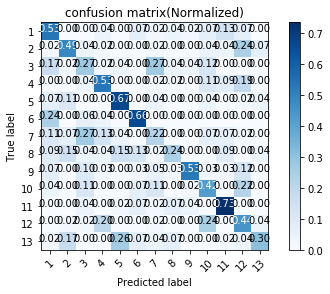

In [200]:
def get_predict(model,X):

    array_p=model.predict([X])
    predict=[np.argmax(i) for i in array_p]
    return  np.array(predict)

prd = get_predict(model,X_test)
confuse_matrix_plot(y_test,prd+1,["1","2","3","4","5","6","7","8","9","10","11","12","13"],title="confusion matrix")

Set3 [ 'Rect-Ch0','Rect-Ch1','Rect-Ch2','Rect-Ch3','Rect-Ch4','Rect-Ch5','Rect-Ch6','Rect-Ch7','ax','ay','az','gx','gy','gz']

In [190]:
Xf3=X[:,[8,9,10,11,12,13,14,15,24,25,26,27,28,29]]

In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( Xf3,y,test_size=0.5,stratify=y)

model=build_model(Xf3.shape[2],Xf3.shape[1])  
model.fit(X_train, pd.get_dummies(y_train), batch_size = 10, nb_epoch = 100)

C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=80, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/100
592/592 [==============================] - 1s 1ms/step - loss: 2.5717 - acc: 0.0693
Epoch 2/100
592/592 [==============================] - 0s 514us/step - loss: 2.5020 - acc: 0.1351
Epoch 3/100
592/592 [==============================] - 0s 478us/step - loss: 2.3003 - acc: 0.2162
Epoch 4/100
592/592 [==============================] - 0s 472us/step - loss: 2.0290 - acc: 0.2753
Epoch 5/100
592/592 [==============================] - 0s 477us/step - loss: 1.8903 - acc: 0.3311
Epoch 6/100
592/592 [==============================] - 0s 482us/step - loss: 1.7285 - acc: 0.3986
Epoch 7/100
592/592 [==============================] - 0s 478us/step - loss: 1.5707 - acc: 0.4257
Epoch 8/100
592/592 [==============================] - 0s 475us/step - loss: 1.3462 - acc: 0.5051
Epoch 9/100
592/592 [==============================] - 0s 480us/step - loss: 1.0808 - acc: 0.6216
Epoch 10/100
592/592 [==============================] - 0s 477us/step - loss: 0.9371 - acc: 0.6706
Epoch 11/100
592/592 

In [193]:
scores = model.evaluate([X_test], pd.get_dummies(y_test))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

592/592 [==============================] - 0s 357us/step

acc: 62.33%


Confusion matrix, without normalization
[[39  0  3  0  0  2  0  0  0  1  0  0  0]
 [ 0 27  1  5  1  0  3  5  0  0  2  1  0]
 [ 3  0 30  0  1  1  5  2  0  6  0  0  0]
 [ 9  0  6 28  0  0  0  1  0  0  0  3  0]
 [ 1  2  4  0 29  0  0  2  0  0  0  1  6]
 [ 2  2  4  0  1 38  1  0  0  0  1  0  0]
 [ 4  1 13  1  2  2 14  1  0  5  2  0  0]
 [ 1  1  1  2  1  3  1 33  0  0  1  0  1]
 [ 2  0  1  0  0  0  0  1 36  1  0  0  0]
 [ 1  0  3  1  1  0  3  1  0 26  0  6  4]
 [ 3  0  1  2  1  0  0  8  1  0 23  0  6]
 [ 3  3  1  6  0  0  3  1  0  6  0 22  0]
 [ 0  8  0  0  5  0  0  8  0  0  1  0 24]]


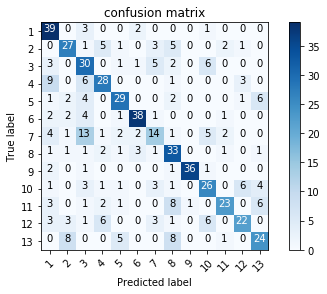

Normalized confusion matrix
[[0.87 0.   0.07 0.   0.   0.04 0.   0.   0.   0.02 0.   0.   0.  ]
 [0.   0.6  0.02 0.11 0.02 0.   0.07 0.11 0.   0.   0.04 0.02 0.  ]
 [0.06 0.   0.62 0.   0.02 0.02 0.1  0.04 0.   0.12 0.   0.   0.  ]
 [0.19 0.   0.13 0.6  0.   0.   0.   0.02 0.   0.   0.   0.06 0.  ]
 [0.02 0.04 0.09 0.   0.64 0.   0.   0.04 0.   0.   0.   0.02 0.13]
 [0.04 0.04 0.08 0.   0.02 0.78 0.02 0.   0.   0.   0.02 0.   0.  ]
 [0.09 0.02 0.29 0.02 0.04 0.04 0.31 0.02 0.   0.11 0.04 0.   0.  ]
 [0.02 0.02 0.02 0.04 0.02 0.07 0.02 0.73 0.   0.   0.02 0.   0.02]
 [0.05 0.   0.02 0.   0.   0.   0.   0.02 0.88 0.02 0.   0.   0.  ]
 [0.02 0.   0.07 0.02 0.02 0.   0.07 0.02 0.   0.57 0.   0.13 0.09]
 [0.07 0.   0.02 0.04 0.02 0.   0.   0.18 0.02 0.   0.51 0.   0.13]
 [0.07 0.07 0.02 0.13 0.   0.   0.07 0.02 0.   0.13 0.   0.49 0.  ]
 [0.   0.17 0.   0.   0.11 0.   0.   0.17 0.   0.   0.02 0.   0.52]]


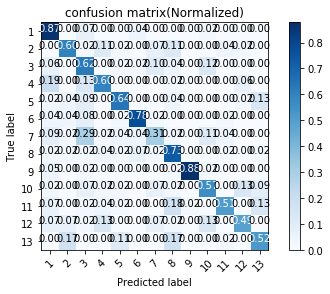

In [194]:
def get_predict(model,X):

    array_p=model.predict([X])
    predict=[np.argmax(i) for i in array_p]
    return  np.array(predict)

prd = get_predict(model,X_test)
confuse_matrix_plot(y_test,prd+1,["1","2","3","4","5","6","7","8","9","10","11","12","13"],title="confusion matrix")

Set5 [ 'Rect-Ch0','Rect-Ch1','Rect-Ch2','Rect-Ch3','Rect-Ch4','Rect-Ch5','Rect-Ch6','Rect-Ch7',['Smooth-Ch0','Smooth-Ch1','Smooth-Ch2','Smooth-Ch3','Smooth-Ch4','Smooth-Ch5','Smooth-Ch6','Smooth-Ch7','ax','ay','az','gx','gy','gz']

In [ ]:
Xf3=X[:]

In [172]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def confuse_matrix_plot(Y,Pred,list_class,title="confusion matrix"):
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(Y, Pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=list_class, normalize=False,
                          title=title)
    plt.show()
      # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=list_class, normalize=True,
                          title=title +'(Normalized)')
    plt.show()
